In [1]:
from sympy import *
init_printing()

## Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Load and visualize data

In [3]:
# Load dataset
file_path_korup_parken = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Bygholm_K\u00f8rup_Parken_VNF_d\u00f8gn_1975-2023.csv"
korup_parken_df = pd.read_csv(file_path_korup_parken, decimal=",", encoding="ISO-8859-1", delimiter=";")

# Clean column names
korup_parken_df.columns = korup_parken_df.columns.str.strip()
korup_parken_df.columns = ["timestamp", "KarupBro", "BygholmPark"]

# Convert timestamp to datetime format
korup_parken_df["timestamp"] = pd.to_datetime(korup_parken_df["timestamp"], format="%d-%m-%Y", errors='coerce')
korup_parken_df["timestamp"] = korup_parken_df["timestamp"].dt.date

# Drop the BygholmPark column
korup_parken_df = korup_parken_df.drop(columns=["BygholmPark"])

# Sort by timestamp
korup_parken_df = korup_parken_df.sort_values("timestamp").reset_index(drop=True)

# Ensure no missing values
korup_parken_df = korup_parken_df.dropna()

korup_parken_df.head()

,timestamp,KarupBro
0,1975-01-01,3854.0
1,1975-01-02,3352.0
2,1975-01-03,2957.0
3,1975-01-04,2801.0
4,1975-01-05,2758.0


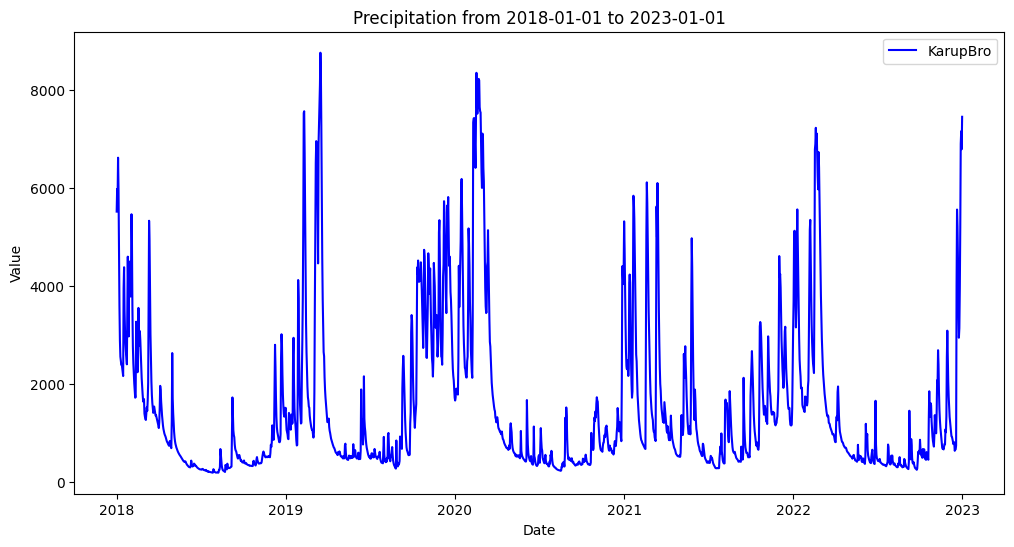

In [4]:
# Date range
start_date = pd.to_datetime("2018-01-01").date()
end_date = pd.to_datetime("2023-01-01").date()

# Filter data
date_filtered_data = korup_parken_df[
    (korup_parken_df["timestamp"] >= start_date) & 
    (korup_parken_df["timestamp"] <= end_date)
]

# Plot the selected time range
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data["timestamp"], date_filtered_data["KarupBro"], label="KarupBro", color='blue')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title(f"Precipitation from {start_date} to {end_date}")
plt.legend()
plt.show()

## Stationarity, ACF, PACF

In [5]:
# Perform Augmented Dickey-Fuller (ADF) test to check stationarity
adf_result = adfuller(date_filtered_data["KarupBro"], autolag='AIC')
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")
if adf_result[1] < 0.05:
    print("The data is likely stationary (reject null hypothesis).")
else:
    print("The data is likely non-stationary (fail to reject null hypothesis).")

ADF Statistic: -5.251928951759652
p-value: 6.8812815329864495e-06
Critical Values:
   1%: -3.4339500836471712
   5%: -2.8631302362582534
   10%: -2.567616588375528
The data is likely stationary (reject null hypothesis).


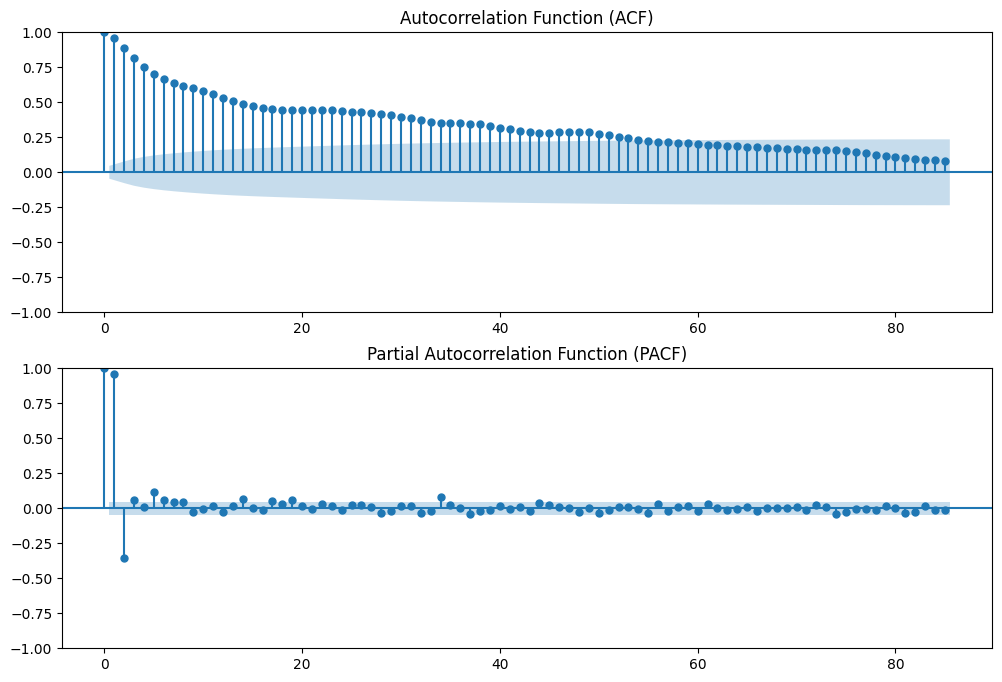

In [6]:
# Plot Autocorrelation and Partial Autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(date_filtered_data["KarupBro"], ax=ax[0], lags=85)
ax[0].set_title("Autocorrelation Function (ACF)")
sm.graphics.tsa.plot_pacf(date_filtered_data["KarupBro"], ax=ax[1], lags=85)
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

## Checking seasonality

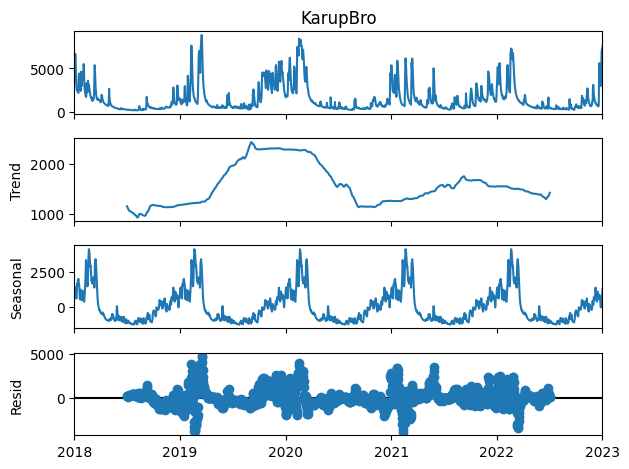

In [7]:
# Perform seasonal decomposition
seasonality = seasonal_decompose(date_filtered_data.set_index("timestamp")["KarupBro"], model="additive", period=365)

# Plot the decomposition
seasonality.plot()
plt.show()

/var/folders/rg/5qwcvj1934v3254xfppzsxm80000gn/T/ipykernel_26869/2708054878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filtered_data["KarupBro_seasonal_diff"] = date_filtered_data["KarupBro"].diff(365)


ADF Statistic: -6.35713936228404
p-value: 2.526494370570796e-08


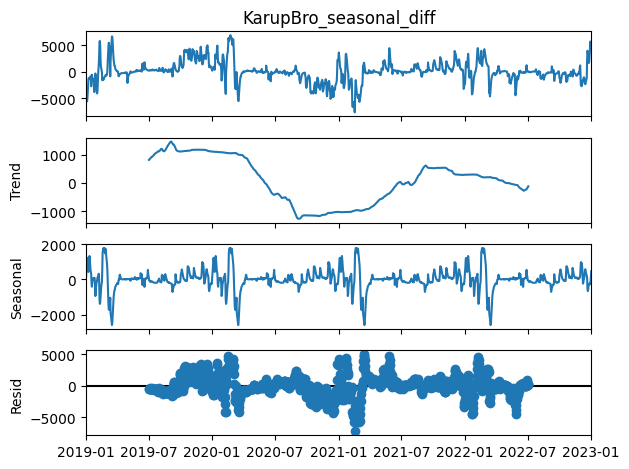

In [8]:
# Seasonal differencing (removes yearly seasonality)
date_filtered_data["KarupBro_seasonal_diff"] = date_filtered_data["KarupBro"].diff(365)

# Drop NaNs before applying the ADF test and decomposition
date_filtered_data = date_filtered_data.dropna(subset=["KarupBro_seasonal_diff"])

# Check stationarity after differencing
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(date_filtered_data["KarupBro_seasonal_diff"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Perform seasonal decomposition
seasonality_diff = seasonal_decompose(date_filtered_data.set_index("timestamp")["KarupBro_seasonal_diff"], model="additive", period=365)

# Plot the decomposition
seasonality_diff.plot()
plt.show()

ADF Statistic: -5.918350645621075
p-value: 2.541097293697075e-07


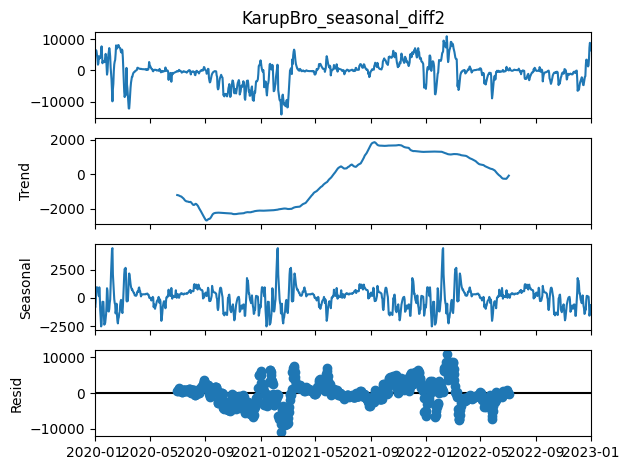

In [9]:
# Seasonal differencing (removes yearly seasonality)
date_filtered_data["KarupBro_seasonal_diff2"] = date_filtered_data["KarupBro_seasonal_diff"].diff(365)

# Drop NaNs before applying the ADF test and decomposition
date_filtered_data = date_filtered_data.dropna(subset=["KarupBro_seasonal_diff2"])

# Check stationarity after differencing
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(date_filtered_data["KarupBro_seasonal_diff2"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Perform seasonal decomposition
seasonality_diff = seasonal_decompose(date_filtered_data.set_index("timestamp")["KarupBro_seasonal_diff2"], model="additive", period=365)

# Plot the decomposition
seasonality_diff.plot()
plt.show()

## SARIMA Model

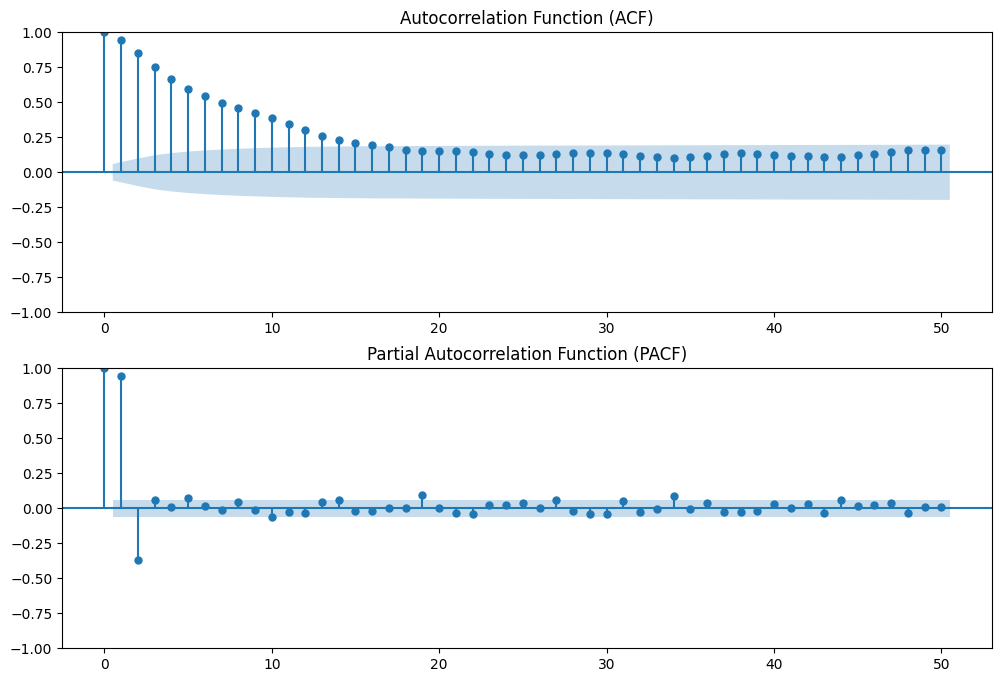

In [10]:
# Plot ACF and PACF to determine p, q for ARIMA component
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(date_filtered_data["KarupBro_seasonal_diff"], lags=50, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")
sm.graphics.tsa.plot_pacf(date_filtered_data["KarupBro_seasonal_diff"], lags=50, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 3.701843
         Iterations: 6
         Function evaluations: 541


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


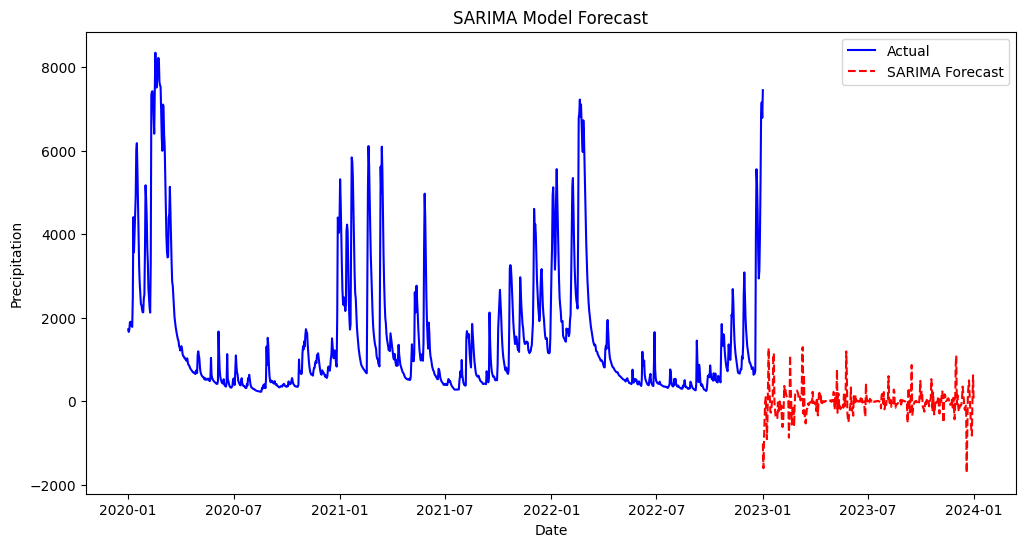

In [12]:
# Define SARIMA parameters
p, d, q = 3, 1, 3  # Determined from PACF and ACF
P, D, Q, S = 1, 1, 1, 365  # Seasonal components (S=365 for yearly)

# Fit SARIMA model
sarima_model = SARIMAX(date_filtered_data["KarupBro"], 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, S),
                        enforce_stationarity=False, 
                        enforce_invertibility=False,
                        simple_differencing=True)
# Use Powell optimizer for speed
sarima_fit = sarima_model.fit(method="powell", disp=True)

# Forecast
forecast_steps = 365  # Predict one year ahead
forecast_index = pd.date_range(start=date_filtered_data["timestamp"].iloc[-1], periods=forecast_steps, freq='D')
sarima_forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_values = sarima_forecast.predicted_mean

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data["timestamp"], date_filtered_data["KarupBro"], label="Actual", color="blue")
plt.plot(forecast_index, forecast_values, label="SARIMA Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("SARIMA Model Forecast")
plt.legend()
plt.show()

## Results

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


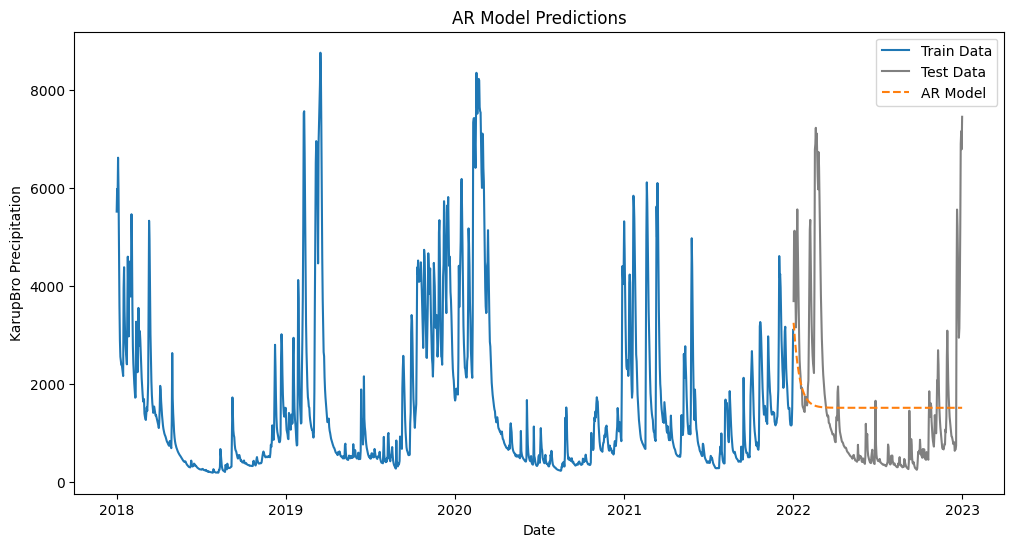

In [ ]:
# Split train and test
train = date_filtered_data.iloc[:-int(len(date_filtered_data) * 0.2)]
test = date_filtered_data.iloc[-int(len(date_filtered_data) * 0.2):]

# --- Autoregression (AR) Model with 4 lags ---
model_ar = AutoReg(train["KarupBro"], lags=4).fit()
pred_ar = model_ar.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# --- Plot results ---
plt.figure(figsize=(12, 6))
plt.plot(train["timestamp"], train["KarupBro"], label="Train Data")
plt.plot(test["timestamp"], test["KarupBro"], label="Test Data", color='gray')
plt.plot(test["timestamp"], pred_ar, label="AR Model", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("KarupBro Precipitation")
plt.title("AR Model Predictions")
plt.legend()
plt.show()